In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Set a random seed for reproducibility
RANDOM_STATE = 42

In [2]:
file_path = '/Users/kd/Downloads/STA 141C/clean_crash_data.csv'
df = pd.read_csv(file_path)

In [3]:
df.head()

,CRASH DATETIME,DAY OF WEEK CODE,DAY OF WEEK DESCRIPTION,CRASH CLASSIFICATION CODE,CRASH CLASSIFICATION DESCRIPTION,COLLISION ON PRIVATE PROPERTY,PEDESTRIAN INVOLVED,MANNER OF IMPACT CODE,MANNER OF IMPACT DESCRIPTION,ALCOHOL INVOLVED,...,LONGITUDE,PRIMARY CONTRIBUTING CIRCUMSTANCE CODE,PRIMARY CONTRIBUTING CIRCUMSTANCE DESCRIPTION,SCHOOL BUS INVOLVED CODE,SCHOOL BUS INVOLVED DESCRIPTION,WORK ZONE,WORKERS PRESENT,the_geom,COUNTY CODE,COUNTY NAME
0,11/16/2023 05:10:00 PM +0000,5,Thursday,2,Property Damage Only,N,N,1.0,Front to rear,N,...,-75.59441,8.0,Following too close,0.0,No,N,N,POINT (-75.594409999839 38.657869999717),S,Sussex
1,08/21/2022 06:51:00 PM +0000,1,Sunday,3,Personal Injury Crash,N,N,3.0,Angle,N,...,-75.29074,12.0,Driving in a careless or reckless manner,0.0,No,N,N,POINT (-75.290739999562 38.585200000283),S,Sussex
2,01/19/2018 04:30:00 PM +0000,6,Friday,2,Property Damage Only,N,N,99.0,Unknown,N,...,-75.05662,99.0,Unknown,0.0,No,N,N,POINT (-75.056620000321 38.538260000222),S,Sussex
3,06/05/2018 04:30:00 PM +0000,3,Tuesday,1,Non-Reportable,Y,N,4.0,"Sideswipe, same direction",N,...,-75.64020,11.0,"Driver inattention, distraction, or fatigue",0.0,No,N,N,POINT (-75.640199999988 39.292560000244),K,Kent
4,08/07/2023 01:02:00 PM +0000,2,Monday,1,Non-Reportable,Y,N,1.0,Front to rear,N,...,-75.14624,88.0,Other,0.0,No,N,N,POINT (-75.146239999738 38.740379999925),S,Sussex


In [4]:
target_variable = 'CRASH CLASSIFICATION CODE'

In [5]:
y = df[target_variable]
drop_columns = [target_variable, 'the_geom', 'CRASH DATETIME', 'CRASH CLASSIFICATION DESCRIPTION']
X = df.drop(columns=drop_columns, axis=1)

In [6]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [7]:
print(f"\nIdentified Numerical features for preprocessing: {numerical_features}")
print(f"Identified Categorical features for preprocessing: {categorical_features}")


Identified Numerical features for preprocessing: ['DAY OF WEEK CODE', 'MANNER OF IMPACT CODE', 'ROAD SURFACE CODE', 'LIGHTING CONDITION CODE', 'WEATHER 1 CODE', 'LATITUDE', 'LONGITUDE', 'PRIMARY CONTRIBUTING CIRCUMSTANCE CODE', 'SCHOOL BUS INVOLVED CODE']
Identified Categorical features for preprocessing: ['DAY OF WEEK DESCRIPTION', 'COLLISION ON PRIVATE PROPERTY', 'PEDESTRIAN INVOLVED', 'MANNER OF IMPACT DESCRIPTION', 'ALCOHOL INVOLVED', 'DRUG INVOLVED', 'ROAD SURFACE DESCRIPTION', 'LIGHTING CONDITION DESCRIPTION', 'WEATHER 1 DESCRIPTION', 'SEATBELT USED', 'MOTORCYCLE INVOLVED', 'MOTORCYCLE HELMET USED', 'BICYCLED INVOLVED', 'BICYCLE HELMET USED', 'PRIMARY CONTRIBUTING CIRCUMSTANCE DESCRIPTION', 'SCHOOL BUS INVOLVED DESCRIPTION', 'WORK ZONE', 'WORKERS PRESENT', 'COUNTY CODE', 'COUNTY NAME']


XGBoost prefers that we start our indexing at 0.

In [9]:
y_processed = y - 1

In [10]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# For categorical features:
# We'll use OneHotEncoder.
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

print("\nNumeric transformer defined:")
print(numeric_transformer)
print("\nCategorical transformer defined:")
print(categorical_transformer)


Numeric transformer defined:
Pipeline(steps=[('scaler', StandardScaler())])

Categorical transformer defined:
Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])


In [11]:
# First, we create a list of transformer instructions.
# Each instruction is a tuple: (name, transformer_object, list_of_columns_to_apply_it_to)
transformers_list = []

# Add the numeric transformer instruction IF you have numerical features
if numerical_features:  # This list was defined when you inspected your X columns
    transformers_list.append(
        ('num',                  # A name for this step (e.g., "numerical processing")
         numeric_transformer,    # The pipeline we defined for numerical data (StandardScaler)
         numerical_features)     # The list of column names to apply it to
    )
    print(f"\nAdded numeric_transformer for columns: {numerical_features}")
else:
    print("\nNo numerical features to add to the ColumnTransformer.")

# Add the categorical transformer instruction IF you have categorical features
if categorical_features: # This list was also defined earlier
    transformers_list.append(
        ('cat',                  # A name for this step (e.g., "categorical processing")
         categorical_transformer,# The pipeline we defined for categorical data (OneHotEncoder)
         categorical_features)   # The list of column names to apply it to
    )
    print(f"Added categorical_transformer for columns: {categorical_features}")
else:
    print("\nNo categorical features to add to the ColumnTransformer.")


# Now, create the ColumnTransformer object
if not transformers_list:
    print("\nWarning: No transformers were added to the list.")
    print("This means no columns were specified as numerical or categorical for preprocessing.")
    print("The 'preprocessor' will be set to 'passthrough', meaning it won't change your data.")
    preprocessor = 'passthrough' # Or you might want to handle this as an error
else:
    preprocessor = ColumnTransformer(
        transformers=transformers_list,
        remainder='passthrough'  # What to do with columns NOT listed in numerical_features or categorical_features
                                 # 'passthrough' means keep them as they are.
                                 # 'drop' would mean remove them.
    )
    print("\nColumnTransformer 'preprocessor' created successfully.")
    print("It's configured to process your specified numerical and categorical columns.")

# You can print the preprocessor to see its structure
print("\nThe 'preprocessor' object looks like this:")
print(preprocessor)


Added numeric_transformer for columns: ['DAY OF WEEK CODE', 'MANNER OF IMPACT CODE', 'ROAD SURFACE CODE', 'LIGHTING CONDITION CODE', 'WEATHER 1 CODE', 'LATITUDE', 'LONGITUDE', 'PRIMARY CONTRIBUTING CIRCUMSTANCE CODE', 'SCHOOL BUS INVOLVED CODE']
Added categorical_transformer for columns: ['DAY OF WEEK DESCRIPTION', 'COLLISION ON PRIVATE PROPERTY', 'PEDESTRIAN INVOLVED', 'MANNER OF IMPACT DESCRIPTION', 'ALCOHOL INVOLVED', 'DRUG INVOLVED', 'ROAD SURFACE DESCRIPTION', 'LIGHTING CONDITION DESCRIPTION', 'WEATHER 1 DESCRIPTION', 'SEATBELT USED', 'MOTORCYCLE INVOLVED', 'MOTORCYCLE HELMET USED', 'BICYCLED INVOLVED', 'BICYCLE HELMET USED', 'PRIMARY CONTRIBUTING CIRCUMSTANCE DESCRIPTION', 'SCHOOL BUS INVOLVED DESCRIPTION', 'WORK ZONE', 'WORKERS PRESENT', 'COUNTY CODE', 'COUNTY NAME']

ColumnTransformer 'preprocessor' created successfully.
It's configured to process your specified numerical and categorical columns.

The 'preprocessor' object looks like this:
ColumnTransformer(remainder='passthro

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_processed, test_size=0.2, random_state=RANDOM_STATE, stratify=y_processed
)

#rus = RandomUnderSampler(random_state=RANDOM_STATE)
#X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [13]:
if preprocessor == 'passthrough':
    print("Preprocessor is 'passthrough'. Converting X_train/X_test to numpy arrays if they are DataFrames.")
    X_train_processed = X_train.values if hasattr(X_train, 'values') else X_train
    X_test_processed = X_test.values if hasattr(X_test, 'values') else X_test
else:
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

In [25]:
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (429268, 29), X_test shape: (107318, 29)
y_train shape: (429268,), y_test shape: (107318,)


In [27]:
model_performance = {}
label_mapping = {
    0: "Non-Reportable",
    1: "Property Damage Only",
    2: "Personal Injury Crash",
    3: "Fatality Crash"
}


--- Logistic Regression ---
Accuracy: 0.6712
Classification Report:
                        precision    recall  f1-score   support

       Non-Reportable       0.81      0.43      0.56     29588
 Property Damage Only       0.65      0.94      0.77     60518
Personal Injury Crash       0.67      0.13      0.21     16877
       Fatality Crash       0.53      0.03      0.06       335

             accuracy                           0.67    107318
            macro avg       0.66      0.38      0.40    107318
         weighted avg       0.70      0.67      0.62    107318



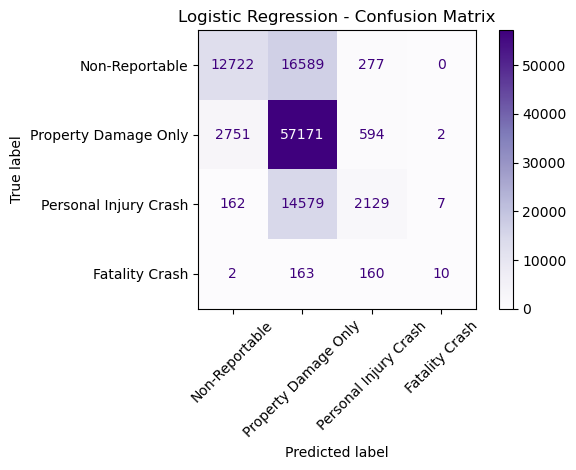

In [39]:
print("\n--- Logistic Regression ---")
log_reg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver='liblinear')
log_reg.fit(X_train_processed, y_train)
y_pred_log_reg = log_reg.predict(X_test_processed)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
report_log_reg = classification_report(y_test, y_pred_log_reg, target_names=[label_mapping[i] for i in sorted(label_mapping)], zero_division=0)
model_performance['Logistic Regression'] = accuracy_log_reg
print(f"Accuracy: {accuracy_log_reg:.4f}")
print("Classification Report:\n", report_log_reg)

cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg, display_labels=[label_mapping[i] for i in sorted(label_mapping)])
disp_log_reg.plot(cmap=plt.cm.Purples, xticks_rotation=45)
plt.title("Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.savefig("/Users/kd/Downloads/STA 141C/log.png", dpi=300)
plt.show()


--- Random Forest ---
Accuracy: 0.6175
Classification Report:
                        precision    recall  f1-score   support

       Non-Reportable       0.61      0.53      0.57     29588
 Property Damage Only       0.66      0.76      0.71     60518
Personal Injury Crash       0.38      0.27      0.31     16877
       Fatality Crash       0.36      0.14      0.20       335

             accuracy                           0.62    107318
            macro avg       0.50      0.42      0.45    107318
         weighted avg       0.60      0.62      0.61    107318



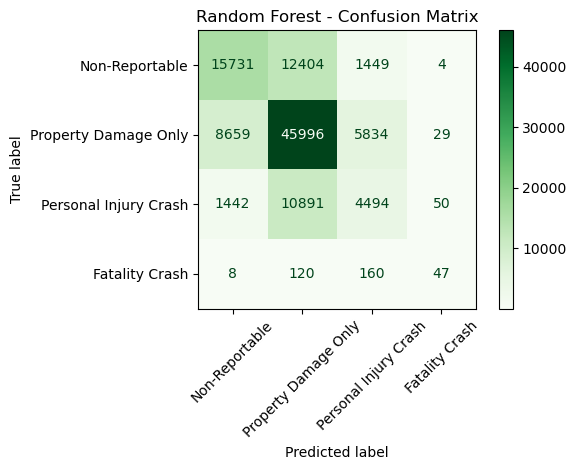

In [40]:
print("\n--- Random Forest ---")
rf_clf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
rf_clf.fit(X_train_processed, y_train)
y_pred_rf = rf_clf.predict(X_test_processed)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, target_names=[label_mapping[i] for i in sorted(label_mapping)], zero_division=0)
model_performance['Random Forest'] = accuracy_rf
print(f"Accuracy: {accuracy_rf:.4f}")
print("Classification Report:\n", report_rf)

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[label_mapping[i] for i in sorted(label_mapping)])
disp_rf.plot(cmap=plt.cm.Greens, xticks_rotation=45)
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.savefig("/Users/kd/Downloads/STA 141C/rf.png", dpi=300)
plt.show()


--- K-Nearest Neighbors (KNN) ---
Accuracy: 0.6166
Classification Report:
                        precision    recall  f1-score   support

       Non-Reportable       0.57      0.53      0.55     29588
 Property Damage Only       0.65      0.78      0.71     60518
Personal Injury Crash       0.42      0.19      0.26     16877
       Fatality Crash       0.45      0.04      0.08       335

             accuracy                           0.62    107318
            macro avg       0.53      0.39      0.40    107318
         weighted avg       0.59      0.62      0.59    107318



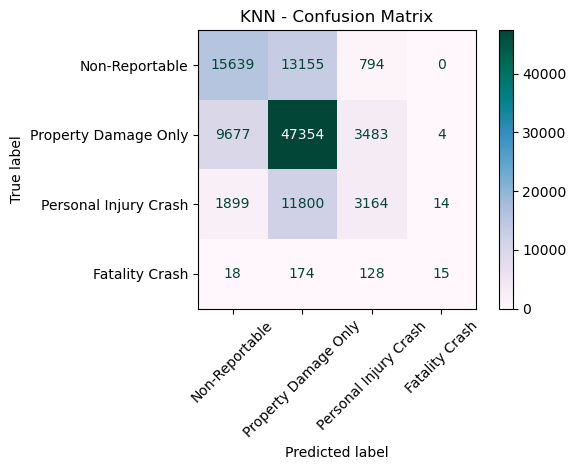

In [41]:
print("\n--- K-Nearest Neighbors (KNN) ---")
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_processed, y_train)
y_pred_knn = knn_clf.predict(X_test_processed)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn, target_names=[label_mapping[i] for i in sorted(label_mapping)], zero_division=0)
model_performance['KNN'] = accuracy_knn
print(f"Accuracy: {accuracy_knn:.4f}")
print("Classification Report:\n", report_knn)

cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=[label_mapping[i] for i in sorted(label_mapping)])
disp_knn.plot(cmap=plt.cm.PuBuGn, xticks_rotation=45)
plt.title("KNN - Confusion Matrix")
plt.tight_layout()
plt.savefig("/Users/kd/Downloads/STA 141C/knn.png", dpi=300)
plt.show()


--- XGBoost ---


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:33:14] WARNING: /private/var/folders/mx/82jnz9m93tl21fhm2b60v38r0000gn/T/pip-install-n5lq4j8l/xgboost_ca1c368fb7274bfaa256d8916979151d/cpp_src/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.6784
Classification Report:
                        precision    recall  f1-score   support

       Non-Reportable       0.78      0.48      0.59     29588
 Property Damage Only       0.66      0.93      0.77     60518
Personal Injury Crash       0.65      0.15      0.24     16877
       Fatality Crash       0.55      0.16      0.25       335

             accuracy                           0.68    107318
            macro avg       0.66      0.43      0.46    107318
         weighted avg       0.69      0.68      0.64    107318



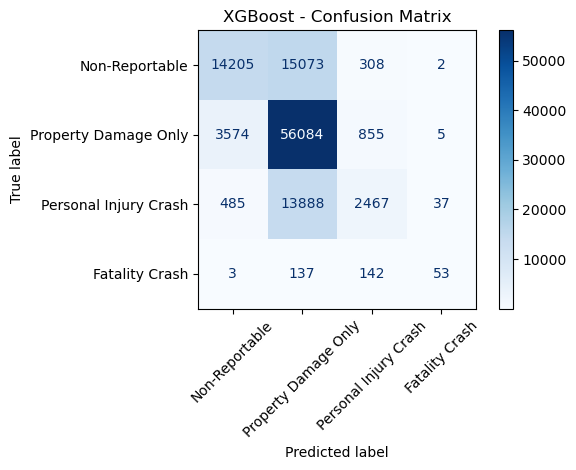

In [42]:
print("\n--- XGBoost ---")
# y_train should be 0-indexed for XGBoost, which y_processed should be.
xgb_clf = xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train_processed, y_train)
y_pred_xgb = xgb_clf.predict(X_test_processed)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb, target_names=[label_mapping[i] for i in sorted(label_mapping)], zero_division=0)
model_performance['XGBoost'] = accuracy_xgb
print(f"Accuracy: {accuracy_xgb:.4f}")
print("Classification Report:\n", report_xgb)

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[label_mapping[i] for i in sorted(label_mapping)])
disp_xgb.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("XGBoost - Confusion Matrix")
plt.tight_layout()
plt.savefig("/Users/kd/Downloads/STA 141C/xgb.png", dpi=300)
plt.show()

In [33]:
print("\n--- Model Performance Summary (Accuracy) ---")
performance_df = pd.DataFrame.from_dict(model_performance, orient='index', columns=['Accuracy'])
print(performance_df.sort_values(by='Accuracy', ascending=False))


--- Model Performance Summary (Accuracy) ---
                     Accuracy
XGBoost              0.678442
Logistic Regression  0.671201
Random Forest        0.617492
KNN                  0.616597


#### CV for sampling

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, recall_score, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", message="Found unknown categories.*", category=UserWarning)
RANDOM_STATE = 42

cat_cols = X_train.select_dtypes(include='object').columns
num_cols = X_train.select_dtypes(include='number').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

clf = RandomForestClassifier(random_state=RANDOM_STATE)

recall_macro = make_scorer(recall_score, average='macro')
f1_macro = make_scorer(f1_score, average='macro')
accuracy = make_scorer(accuracy_score)

preprocessor.fit(X_train)

X_small = X_train.sample(n=15000, random_state=RANDOM_STATE)
y_small = y_train.loc[X_small.index]

In [ ]:
pipe_base = Pipeline([
    ('preprocess', preprocessor),
    ('clf', clf)
])
pipe_weighted = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=30, class_weight='balanced', random_state=RANDOM_STATE))
])
pipe_smote = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE))
])
pipe_undersample = ImbPipeline([
    ('preprocess', preprocessor),
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf', clf)
])

In [ ]:
# substitute scoring= as needed
print("Baseline:")
print(cross_val_score(pipe_base, X_small, y_small, scoring=f1_macro, cv=3).mean())

print("Class Weights:")
print(cross_val_score(pipe_weighted, X_small, y_small, scoring=f1_macro, cv=3).mean())

print("SMOTE:")
print(cross_val_score(pipe_smote, X_small, y_small, scoring=f1_macro, cv=3, n_jobs=-1))

print("Undersampling:")
print(cross_val_score(pipe_undersample, X_small, y_small, scoring=f1_macro, cv=3).mean())
